In [1]:
### Get images with kaggle
# import kagglehub

# Download latest version
# path = kagglehub.dataset_download("adityajn105/flickr30k")

In [2]:
import os
import PIL
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import json

import torch
from datasets import Dataset, Image
from torch.utils.data import DataLoader
import torch.nn as nn

from typing import List, Union, Tuple

from transformers import CLIPProcessor, CLIPModel

import faiss # to use gpu version need python3.8
import clip

2025-04-15 20:28:39.240236: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 20:28:39.241969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 20:28:39.273365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-15 20:28:40.313042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
device = "cuda" #setting up cuda

# loading CLIP model and its processor
model, preprocess = clip.load("ViT-B/32", device=device)

# getting image paths
import os

# Define the base directory where your images are stored
base_dir = './smallDataset/'

# Get all image file paths in the directory that end with .jpg
image_path = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.jpg')]
for imageName in [os.path.join("./fineTuning/", f) for f in os.listdir("./fineTuning/") if f.endswith('.jpg')]:
    image_path.append(imageName)
image_path.sort()

In [4]:
with open("./fineTuning/captions.json", 'r') as file:
    imagePaths = []
    captions = []
    for line in file:
        data = json.loads(line)
        imagePaths.append(f'./fineTuning/{data["Image"]}')
        captions.append(data["Caption"])

class CustomDataset():
    def __init__(self, list_image_path,list_txt):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.title  = clip.tokenize(list_txt)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(PIL.Image.open(self.image_path[idx]))
        title = self.title[idx]
        return image, title

trainDataloader = DataLoader(CustomDataset(imagePaths, captions), batch_size=32, shuffle=True)

In [5]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        if p.data is not None:
            p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

# Fine tune the model to look for pictures of us
optimizer = torch.optim.Adam(model.parameters())
imageLoss = nn.CrossEntropyLoss()
textLoss = nn.CrossEntropyLoss()

epochs = 30

for epoch in range(epochs):
    pbar = tqdm(trainDataloader, total=len(trainDataloader))
    for batch in pbar:
        optimizer.zero_grad()
    
        images, texts = batch
        images = images.to(device)
        texts = texts.to(device)
    
        image_features = model.encode_image(images)
        text_features = model.encode_text(texts)
    
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
        logits_per_image = model.logit_scale.exp() * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()
    
        groundTruth = torch.arange(len(images), dtype=torch.long, device=device)

        loss = (imageLoss(logits_per_image, groundTruth) + textLoss(logits_per_text, groundTruth)) / 2
        loss.backward()
    
        convert_models_to_fp32(model)
        optimizer.step()
        clip.model.convert_weights(model)
    
        pbar.set_description(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.8f}")

Epoch 30/30, Loss: 1.38671875: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


In [6]:
#this bassically querys some vlm to make descriptions of images and vectorize them
def encode_images(images: Union[List[str], List[PIL.Image.Image]], batch_size: int):
    def transform_fn(batch):
        imgs = []
        for item in batch["image"]:
            if isinstance(item, PIL.Image.Image):
                img = item
            else:
                img = Image().decode_example(item)
            imgs.append(preprocess(img))
        
        # Stack into a batch tensor
        pixel_values = torch.stack(imgs)
        return {"pixel_values": pixel_values}
        
    dataset = Dataset.from_dict({'image': images})
    dataset = dataset.cast_column('image',Image(decode=False)) if isinstance(images[0], str) else dataset       
    dataset.set_format('torch')
    dataset.set_transform(transform_fn)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    image_embeddings = []
    pbar = tqdm(total=len(images) // batch_size, position=0)
    with torch.no_grad():
        for batch in dataloader:
            images = batch["pixel_values"].to(device)
            image_features = model.encode_image(images)
            image_embeddings.extend(image_features.cpu().numpy())
            pbar.update(1)
        pbar.close()
    return np.stack(image_embeddings)

vector_embedding = np.array(encode_images(image_path,32)).astype('float32')

29it [00:12,  2.27it/s]                        


In [7]:
with open('flicker30k_image_embeddings.pkl','wb') as f:
    pickle.dump(vector_embedding, f)

In [8]:
index = faiss.IndexFlatIP(vector_embedding.shape[1])
index.add(vector_embedding)

In [17]:
# takes input text and vectorize it so the to compare for similarity in database
def encode_text( text: List[str], batch_size: int):
    device =  "cuda"
    dataset = Dataset.from_dict({'text': text})
    dataset = dataset.map(lambda el: {"input_ids": clip.tokenize(el["text"])}, batched=True, remove_columns=["text"])
    dataset.set_format('torch')
    dataloader = DataLoader(dataset, batch_size=batch_size)
    text_embeddings = []
    pbar = tqdm(total=len(text) // batch_size + 1, position=0)
    with torch.no_grad():
        for batch in dataloader:
            tokens = batch["input_ids"].to(device)
            embeddings = model.encode_text(tokens)
            text_embeddings.extend(embeddings.detach().cpu().numpy())
            pbar.update(1)
        pbar.close()
    return np.stack(text_embeddings)


search_text = "Playing a board game with my family"
with torch.no_grad():
    text_search_embedding = encode_text([search_text], batch_size=32)
text_search_embedding = text_search_embedding/np.linalg.norm(text_search_embedding, ord=2, axis=-1, keepdims=True).astype('float32')

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 228.49it/s]


In [18]:
# similarity search top two images
distances, indices = index.search(text_search_embedding.reshape(1, -1), 10) #2 represent top n results required
distances = distances[0]
indices = indices[0]

indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1])  # Sort based on the distances

Verifying images... (1/10)
True negative at result 1: ./smallDataset/19622.jpg
Verifying images... (2/10)
True negative at result 2: ./smallDataset/20892.jpg
Verifying images... (3/10)
True negative at result 3: ./smallDataset/23842.jpg
Verifying images... (4/10)
True negative at result 4: ./smallDataset/01217.jpg
Verifying images... (5/10)
True negative at result 5: ./smallDataset/11318.jpg
Verifying images... (6/10)
True negative at result 6: ./smallDataset/16233.jpg
Verifying images... (7/10)
True negative at result 7: ./smallDataset/00160.jpg
Verifying images... (8/10)
True negative at result 8: ./smallDataset/02452.jpg
Verifying images... (9/10)
True positive at result 9: ./fineTuning/20231121_223520.jpg
{'verified': True, 'distance': 0.37938010436462166, 'threshold': 0.68, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 2108, 'y': 603, 'w': 171, 'h': 171, 'left_eye': (2225, 663), 'right_eye': (2156, 666)}, 'img2': {

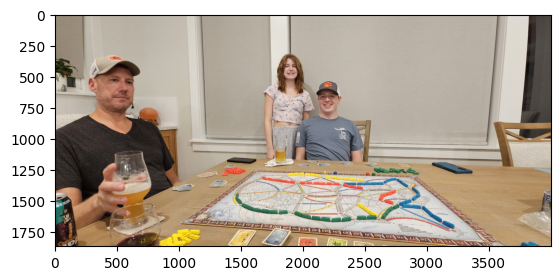

Verifying images... (10/10)
True negative at result 10: ./smallDataset/04305.jpg


In [19]:
# this will output the results
from PIL import Image
from deepface import DeepFace

count = 0
for idx, distance in indices_distances:
    count += 1
    path = image_path[idx]
    result = DeepFace.verify(path, "./wyattFace.jpg", enforce_detection=False)
    print(f"Verifying images... ({count}/{10})")
    
    if result["verified"] and ("./fineTuning" in path):
        im = Image.open(path)
        print(f"True positive at result {count}: {path}")
        print(result)
        plt.imshow(im)
        plt.show()
    elif result["verified"]:
        im = Image.open(path)
        print(f"False positive at result {count}: {path}")
    elif "./fineTuning" in path:
        im = Image.open(path)
        print(f"False negative at result {count}: {path}")
    else:
        im = Image.open(path)
        print(f"True negative at result {count}: {path}")

